## 完全从零写一个小模型
### Build a miniGPT from scratch
- 从零开始构建 SLM
- 运行代码完全手写，一行一行带着运行
- 作者： **chaofa用代码打点酱油**

In [29]:
# part 1: 导入相关的 package
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from dataclasses import dataclass

torch.manual_seed(1024)

In [30]:
@dataclass
class GPTConfig:
    block_size: int = 512   # 这里其实应该是文本的最大长度（ max_seq_len）
    batch_size: int = 12
    n_layer: int = 6
    n_head: int = 12
    n_embd: int = 768    # n_embd 也叫 hidden_dim, hiden_size, 这里我同时设置了和 embed_dim 一样
    head_size: int = n_embd // n_head
    dropout: float = 0.1
    # # tiktoken 使用的是 GPT-2 的词表，大约有 50257 个token
    vocab_size: int = 50257


## 模型结构

In [31]:
class SingleHeadAttention(nn.Module):
    # 单头注意力机制
    def __init__(self, config):
        super().__init__()
        self.key = nn.Linear(config.n_embd, config.head_size)
        self.value = nn.Linear(config.n_embd, config.head_size)
        self.query = nn.Linear(config.n_embd, config.head_size)

        # 尝试学习新的写法，attention_mask 通过 register_buffer 注册
        # 因为不用计算 梯度，所以节约内存和显存，速度也更快
        self.register_buffer(
            'attention_mask', 
            torch.tril(
                torch.ones(config.block_size, config.block_size)
            ))
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        batch_size, seq_len, hidden_size = x.size()
        k = self.key(x)
        v = self.value(x)
        q = self.query(x)
        weight = q @ k.transpose(-2, -1)   # @ 就是 torch.matmul 的简化写法
        weight = weight.masked_fill(
            self.attention_mask[:seq_len, :seq_len] == 0, 
            float('-inf')
        )
        weight = F.softmax(weight, dim=-1)
        weight = self.dropout(weight)
        out = weight @ v
        return out


class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.heads = nn.ModuleList(
            [
                SingleHeadAttention(config)
                for _ in range(config.n_head)
            ]
        )
        self.proj = nn.Linear(config.n_embd, config.n_embd)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        output = torch.cat(
            [h(x) for h in self.heads], 
            dim=-1
        )
        output = self.proj(output)
        output = self.dropout(output)
        return output


class FeedForward(nn.Module):
    # 实际上就是 MLP
    def __init__(self, config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout)
        )
    
    def forward(self, x):
        return self.net(x)


# 接下来就是一个完整的 Block

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        head_size = config.n_embd // config.n_head
        self.att = MultiHeadAttention(config)
        self.ffn = FeedForward(config)
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)

    def forward(self, x):
        x = x + self.att(self.ln1(x))
        x = x + self.ffn(self.ln2(x))
        return x

# 以后会讲  MLA ,  MOE, DPO 完全手写
# 完整的  GPT model
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_embedding_table = nn.Embedding(config.vocab_size, config.n_embd)
        self.position_embedding_table = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.Sequential(
            *[Block(config) for _ in range(config.n_layer)]
        )
        self.ln_final = nn.LayerNorm(config.n_embd)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        
        # linear (4 -> 8)； weight shape 是记上是 8 * 4，
        # 所以 embedding weight 和 lm_head weight 是共享的
        # 这里学习一下 tie weight。
        # 这是为了减少参数，加快训练；（现在 25的 SLM 很多都这样做了，注意⚠️）
        # self.token_embedding_table.weight = self.lm_head.weight

        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            # 这里使用的是正态分布初始化
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        # idx 是输入的 token ids
        batch, seq_len = idx.size()
        token_emb = self.token_embedding_table(idx)

        # seq 长度是这次输入的最大长度
        pos_emb = self.position_embedding_table(
            # 要确保 位置编码和输入的 idx 在同一个设备上
            torch.arange(seq_len, device=idx.device)
        )
        # 有一个经典题目：为什么 embedding 和 position 可以相加？
        x = token_emb + pos_emb   # shape is (batch, seq_len, n_embd)
        x = self.blocks(x)
        x = self.ln_final(x)
        logits = self.lm_head(x)   # shape is (batch, seq_len, vocab_size)
        
        if targets is None:
            loss = None
        else:
            batch, seq_len, vocab_size = logits.size()
            logits = logits.view(batch * seq_len, vocab_size)
            targets = targets.view(batch * seq_len)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # 如果序列太长，只取最后 block_size 个token
            idx_cond = idx if idx.size(1) <= self.block_size else idx[:, -self.block_size:]
            # 获取预测
            logits, _ = self(idx_cond)
            # 只关注最后一个时间步的预测
            logits = logits[:, -1, :]  # becomes (B, vocab_size)
            # 应用softmax获取概率
            probs = F.softmax(logits, dim=-1)
            # 采样下一个token
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            # 附加到序列上
            idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)
        return idx


In [32]:


# 写一个 dataset，为了 Dataloader 准备
class MyDataset(Dataset):
    def __init__(self, path, block_size=512):
        # 我的数据在 /root/fs/mobvoi_seq_monkey_general_open_corpus.jsonl 中，
        # 读取前 1000 行
        import tiktoken
        self.enc = tiktoken.get_encoding("gpt2")
        self.block_size = block_size

        self.eos_token = self.enc.encode(
            "<|endoftext|>",
            allowed_special={"<|endoftext|>"}
        )[0]

        import json

        self.encoded_data = []

        self.max_lines = 1000
        raw_data = []
        with open(path, 'r') as f:
            for i, line in enumerate(f):
                if i >= self.max_lines:
                    break
                try:
                    text = json.loads(line.strip())['text']
                    raw_data.append(text)
                except json.JSONDecodeError:
                    continue
                except Exception as e:
                    continue
        full_encoded = []
        for text in raw_data:
            encoded_text = self.enc.encode(text)
            full_encoded.extend(encoded_text + [self.eos_token])
        
        # 将长文本分割成训练样本
        for i in range(0, len(full_encoded), self.block_size):
            # 多取一个 Token 作为目标
            chunk = full_encoded[i:i+self.block_size+1]
            # 如果长度不够，用 eos_token 填充
            if len(chunk) < self.block_size + 1:
                chunk = chunk + [self.eos_token] * (self.block_size + 1 - len(chunk))
            self.encoded_data.append(chunk)
    
    def __len__(self):
        return len(self.encoded_data)
    
    def __getitem__(self, idx):
        chunk = self.encoded_data[idx]
        x = torch.tensor(chunk[:-1], dtype=torch.long)
        y = torch.tensor(chunk[1:], dtype=torch.long)
        return x, y

    def encode(self, text):
        """将文本编码为token IDs"""
        return self.enc.encode(text)

    def decode(self, ids):
        """将token IDs解码为文本"""
        return self.enc.decode(ids)

In [37]:
# 数据的格式
"""
{"text":"担任地点省市的区域运营中心的办理作业。承受总部相关KPI查核。\n1、了解新闻职业或媒体相关运营运营岗位，其间，应聘区域运营中心主任有3年以上当地干流媒体作业经验者优先，应聘事务主管有2年以上当地干流媒体作业经验者优先。\n2、交流才能强，抗压才能强，长于处理复杂情况，了解GR作业优先，能独立完结策划计划优先。具有独立开发客户才能。\n北京、天津、河北、山西、黑龙江、吉林、辽宁、上海、江苏、浙江、安徽、江西、福建、山东、河南、湖北、湖南、广东、海南、重庆、四川、贵州、云南、陕西等。"}
"""

'\n{"text":"担任地点省市的区域运营中心的办理作业。承受总部相关KPI查核。\n1、了解新闻职业或媒体相关运营运营岗位，其间，应聘区域运营中心主任有3年以上当地干流媒体作业经验者优先，应聘事务主管有2年以上当地干流媒体作业经验者优先。\n2、交流才能强，抗压才能强，长于处理复杂情况，了解GR作业优先，能独立完结策划计划优先。具有独立开发客户才能。\n北京、天津、河北、山西、黑龙江、吉林、辽宁、上海、江苏、浙江、安徽、江西、福建、山东、河南、湖北、湖南、广东、海南、重庆、四川、贵州、云南、陕西等。"}\n'

In [33]:

# train data
train_dataset = MyDataset('/root/fs/mobvoi_seq_monkey_general_open_corpus.jsonl')

# split traindataset to train and val
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.9, 0.1])

train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=12, shuffle=False)



In [34]:
model = GPT(GPTConfig())
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# 打印模型一共有多少参数

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params / 1e6} M")

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
# 设置 cosine 学习率
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000)


Total parameters: 120.116736 M


In [35]:
# 训练循环
def train(model, optimizer, scheduler, train_loader, val_loader, device):
    model.train()
    total_loss = 0
    for batch_idx, (x, y) in enumerate(train_loader):
        # 将数据移到设备上
        x, y = x.to(device), y.to(device)
        
        # 前向传播
        logits, loss = model(x, targets=y)
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 调整学习率
        scheduler.step()
        
        total_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
        return total_loss

def eval(model, val_loader, device):
    # 验证
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits, loss = model(x, targets=y)
            val_loss += loss.item()
    return val_loss


for epoch in range(2):
    train_loss = train(model, optimizer, scheduler, train_loader, val_loader, device)
    val_loss = eval(model, val_loader, device)
    print(f'Epoch: {epoch}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}')

    # 保存模型
    avg_val_loss = val_loss / len(val_loader)
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'val_loss': avg_val_loss,
    }
    # 保存每个epoch的模型
    torch.save(checkpoint, f'checkpoints/model_epoch_{epoch}.pt')
    

Epoch: 0, Batch: 0, Loss: 11.0125
Epoch: 0, Train Loss: 0.0396, Val Loss: 9.9209
Epoch: 1, Batch: 0, Loss: 9.9677
Epoch: 1, Train Loss: 0.0359, Val Loss: 9.2747


##### 写一个 mini/nanoGPT 需要什么东西？
1. 模型结构
    - one head 
    - multi head 
    - causal attention
    - mlp 
    - block
    - gptLayer
2. train / eval 的 function




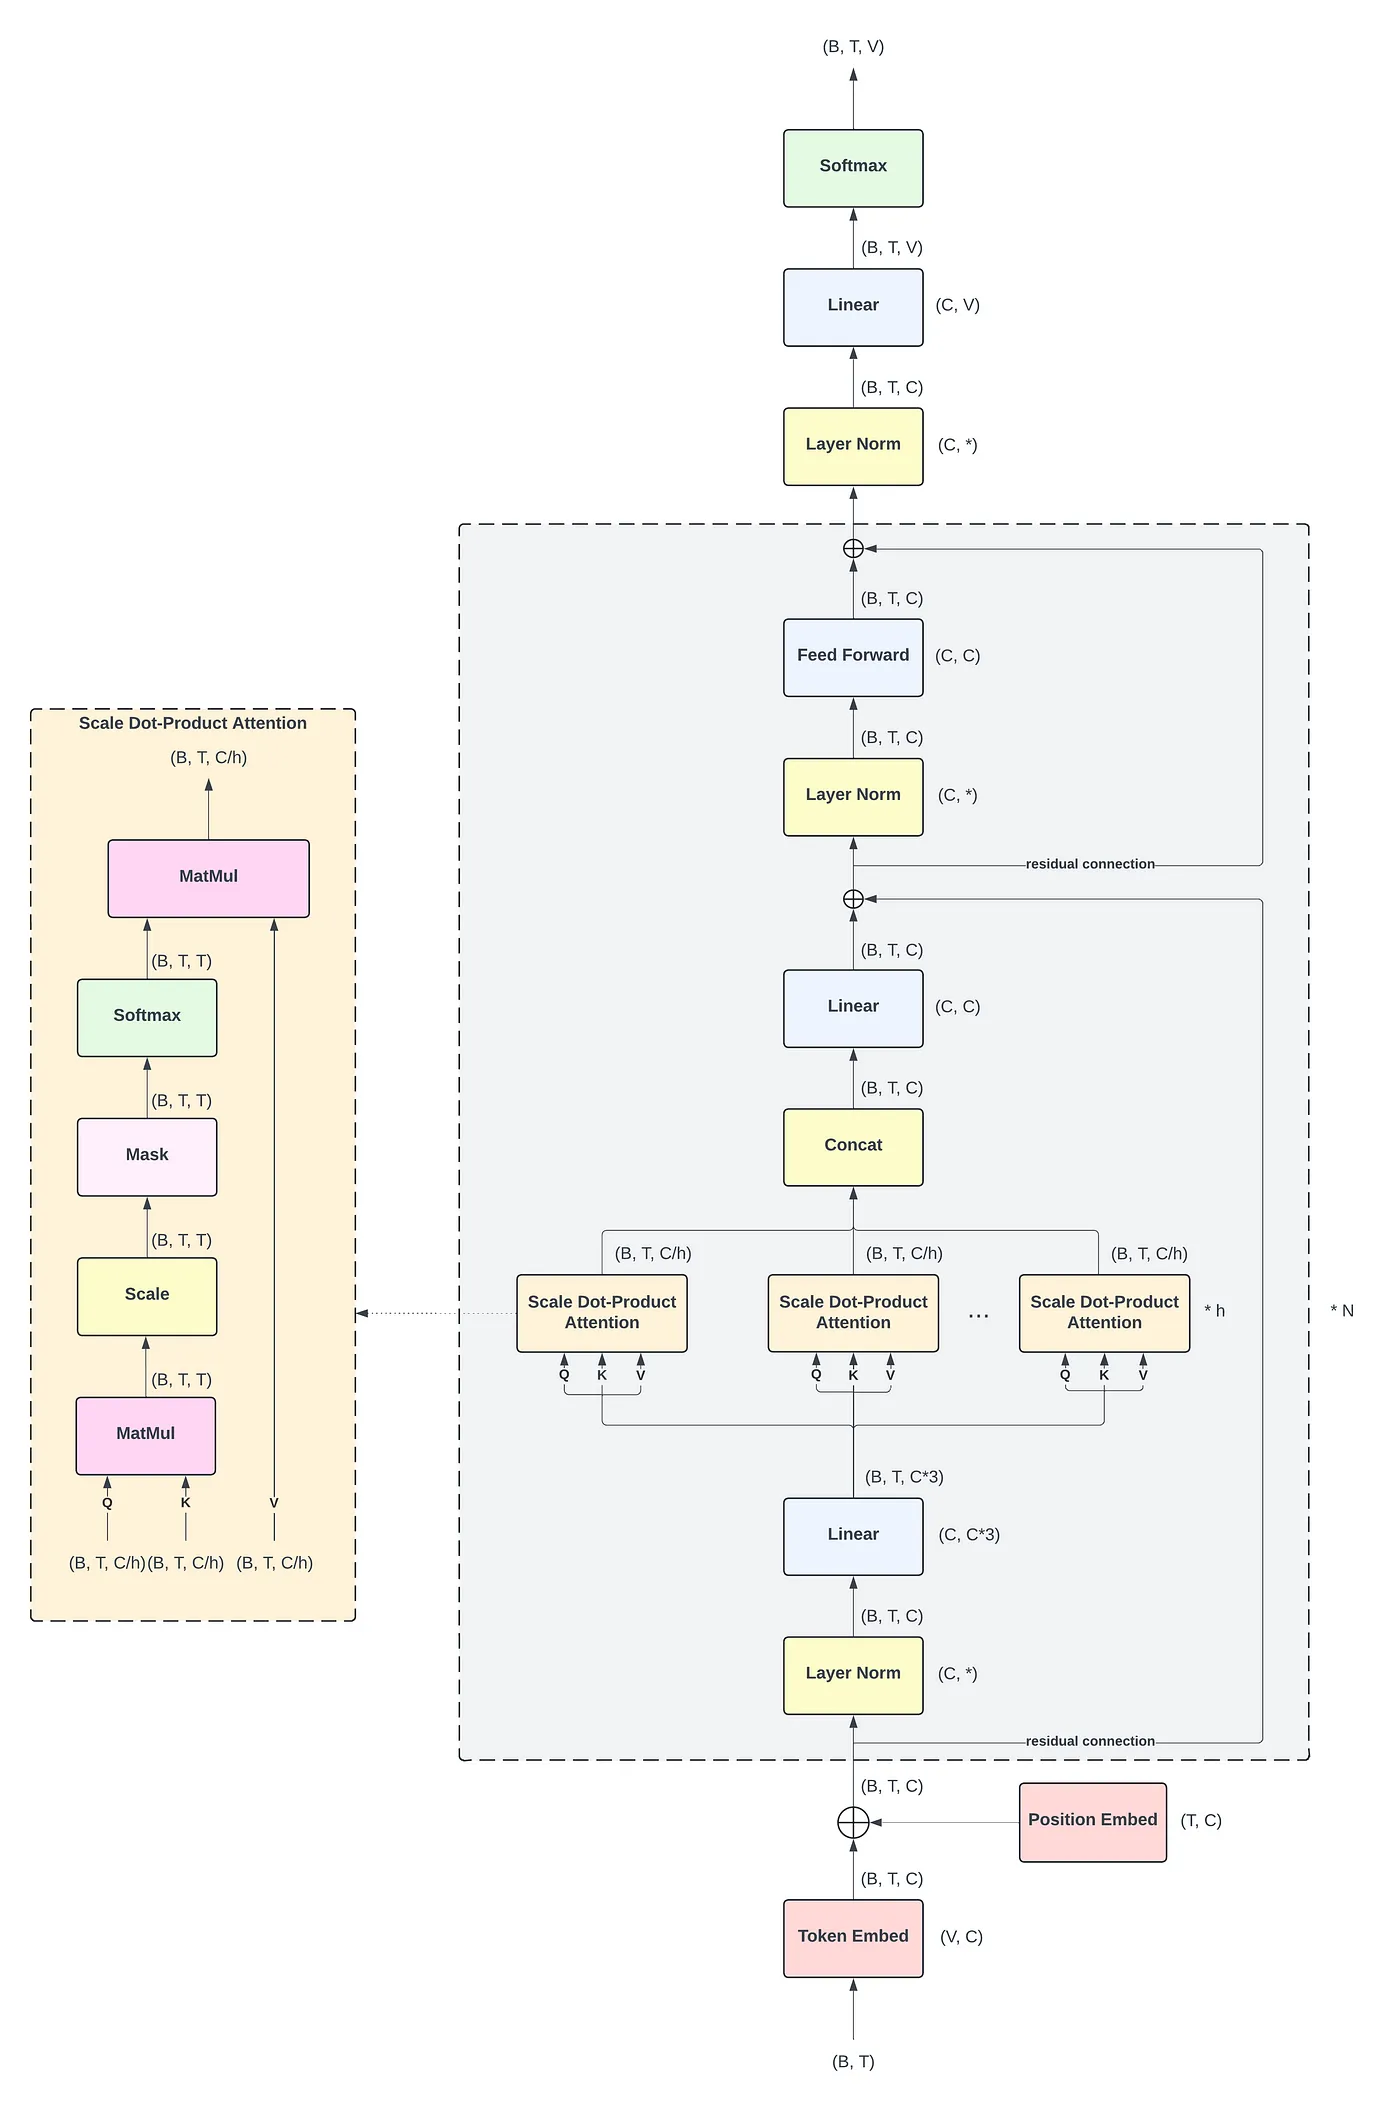

## LLMs Zero to hero

1. 0： 了解 transformers 的结构，了解 大模型训练的 多个阶段
2. 第一章： 用 transformers 的 trainer 跑通 预训练
3. part 所有的细节都自己写
- bpe 算法
- SLM 
- MOE
- 预训练
    - 数据处理流程 (minhash 去重)
    - 规则
    - 其他模型去做质量判断
    - PPL 过滤
    - 垂类识别，做领域的混合；

4. SFT （自己手写，意义不大，凑内容）
    - code LLM (写规则)
    - LLM as judge 去做相关的过滤
5. DPO
    。。。

# VLM 
# 语音大模型
